In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

# from tqdm.notebook import tqdm 
# 
# import tqdm as notebook_tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "retina"

# Basic Concepts

## White Noise

**Definition**: a time series is characterized as **white noise** when it 
consists of a sequence of uncorrelated random variables, commonly modeled as 
Gaussian (normal) random variables:

$$
x_t = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observations*:

* **Mean**: The series has a mean of **zero**.
* **Constant Variance**: The variance of the series remains constant and finite 
over time.
* **No Autocorrelation**: There is no predictable pattern or trend in the series.
Each value is statistically independent of other values, implying no correlation 
between past, present, and future values in the series.



## Random Walk

**Definition**: A time series is characterized as following a **random walk** if, 
and only if, the difference between its consecutive values (i.e., the variation 
at each time step) constitutes *white noise*. 

$$
x_t - x_{t-1} = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observation*: This implies that the changes in the series from one period to the 
next are entirely random and unpredictable, with no discernible pattern or trend, 
meaning that *each change* is **independent** of *past changes*.

# Basic Structural Time Series Model

**Definition** - the **Basic Structural Model** is a framework in time series 
analysis that decomposes a time series into three distinct components: **trend**, 
**cycle**, and **noise**.

$$
y_t = \mu_t + \gamma_t + \epsilon_t
$$

* $\mu_t$: **trend** represents the long-term progression of the series.
* $\gamma_t$: **cycle** accounts for regular but not necessarily seasonal 
fluctuations in the time series.
* $\epsilon_t \sim N(0, \sigma_{\epsilon})$: This is the **random error**, the 
**noise** or the **irregular component** of the series.

## Trends
### Stochastic Trend

The **1-step changes in the trend** are modeled as **random walk** plus 
**white noise**:

$$
\mu_t - \mu_{t-1} = \beta_t + \xi_t \\
\beta_t - \beta_{t-1} = \eta_t
$$

Where:

$$
\xi_t \sim N(0, \sigma_{\mu}) \\
\eta_t \sim N(0, \sigma_{\beta})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1} + \beta_t, \sigma_{\mu}) \\
\beta_t \sim N(\beta_{t-1}, \sigma_{\beta})
$$

*Observation*
Here it is usual to distinguish between:
* **(Local) Level**, $\mu_t$: The baseline value of the series, representing its 
**long-term** average or trend.
* **(Local) Trend**, $\beta_t$: A component that captures the gradual, long-term 
movement in the series. Unlike the level, which is more static, the trend is 
dynamic and can change over time, representing either an upward or downward 
direction in the data.


### Local Level Trend

If $\beta_0 = 0$ and $\sigma_{\beta} = 0$, the stochastic trend is called
*Local Level Trend*.

The **trend** is a **random walk** (equivalent to: "the **1-step changes** in the
trend are modeled as **white noise**"): 

$$
\mu_t - \mu_{t-1} = \xi_t
$$

With:

$$
\xi_t \sim N(0, \sigma_{\mu})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1}, \sigma_{\mu})
$$


## Cycles

# Simulation

In [3]:
import numpy as np
import pandas as pd

def stochastic_trend(
        rng, 
        N = 100, 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 100
        ):
    """Simulate a stochastic trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    # local trend is a random walk
    diff_local_trend = rng.normal(0, sigma_local_trend, N)
    local_trend      = np.cumsum(diff_local_trend) + local_trend_0

    # local level is the local trend plus noise
    diff_local_level = rng.normal(local_trend, sigma_local_level, N)
    local_level      = np.cumsum(diff_local_level) + local_level_0

    # dataframe with t = 1:N, local_trend, local_level
    df = pd.DataFrame(
        {
            "t": np.arange(1, N + 1),
            "local_trend": local_trend,
            "local_level": local_level,
        }
    )
    return df

def plot_stochastic_trend(df):
    """plot local_trend and local_level vs t, each with a different y-axis

    Args:
        df (_type_): _description_
    """
    # plot local_trend and local_level vs t, each with a different y-axis
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    df.plot(x="t", y=["local_trend"], ax=ax1, alpha=0.5)
    df.plot(x="t", y=["local_level"], ax=ax2, alpha=0.5, color="C1")

    # Add y-axis labels
    ax1.set_ylabel("local_trend")
    ax2.set_ylabel("local_level")

    # Add a legend
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Add a title
    plt.title("Local Trend and Local Level")

    # Add horizontal dotted line at local_trend = 0
    ax1.axhline(0, linestyle="--", color="black", alpha=0.5)

    fig.tight_layout()
    plt.show()

def local_level_trend(
        rng, 
        N = 100, 
        sigma = 1, 
        level_0 = 100
        ):
    """simulate a local level trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = 0, 
        sigma_local_level = sigma, 
        local_level_0 = level_0
    )

    return df

def deterministic_trend(
        rng,
        N = 100,
        slope = 1,
        intercept = 100
):
    """simulate a deterministic trend
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = slope, 
        sigma_local_level = 0, 
        local_level_0 = intercept
    )

    return df



In [4]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

## Stochastic Trend

C:\Users\migue\AppData\Local\Temp\ipykernel_21652\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


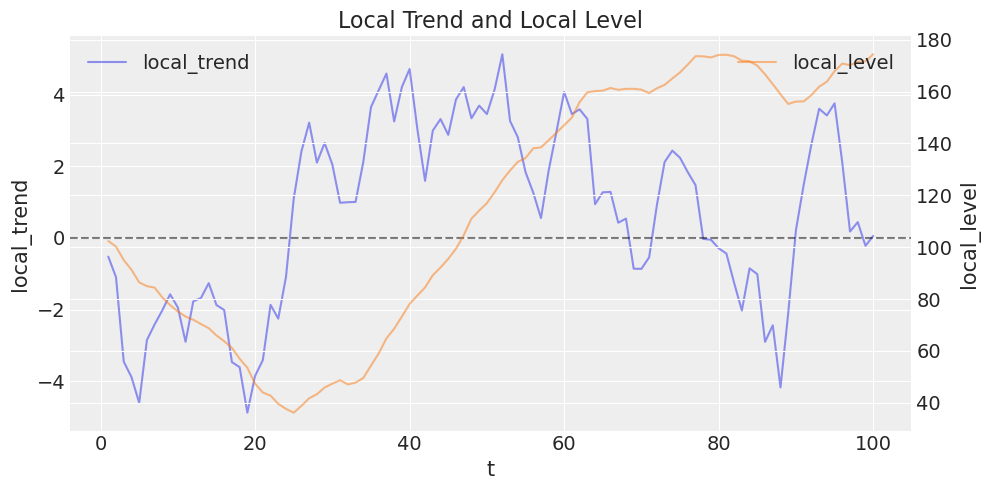

In [5]:
df_stoch_trend = stochastic_trend(
    rng, 
    N = 100, 
    sigma_local_trend = 1, 
    local_trend_0 = 1, 
    sigma_local_level = 1, 
    local_level_0 = 100
    )

plot_stochastic_trend(df_stoch_trend)

C:\Users\migue\AppData\Local\Temp\ipykernel_21652\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


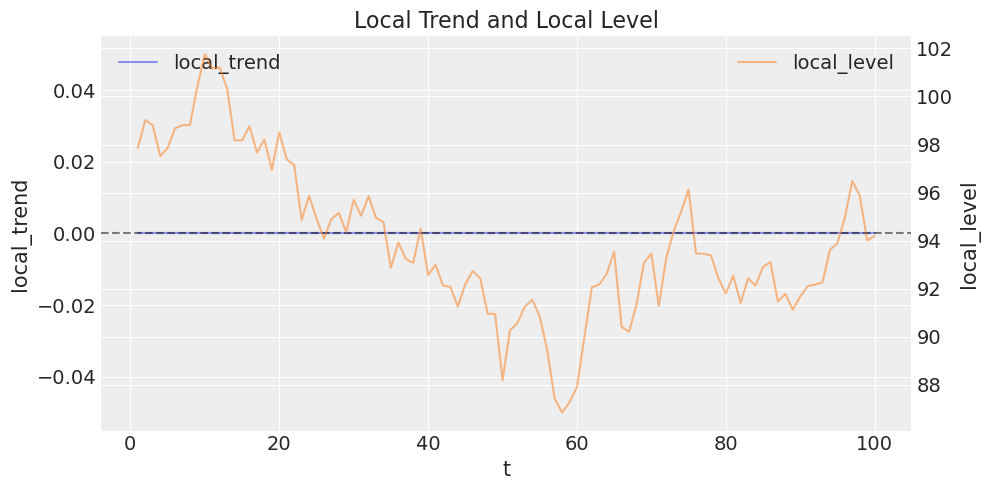

In [6]:
df_local_level_trend = local_level_trend(
    rng, 
    N = 100, 
    sigma = 1, 
    level_0 = 100
    )

plot_stochastic_trend(df_local_level_trend)

C:\Users\migue\AppData\Local\Temp\ipykernel_21652\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


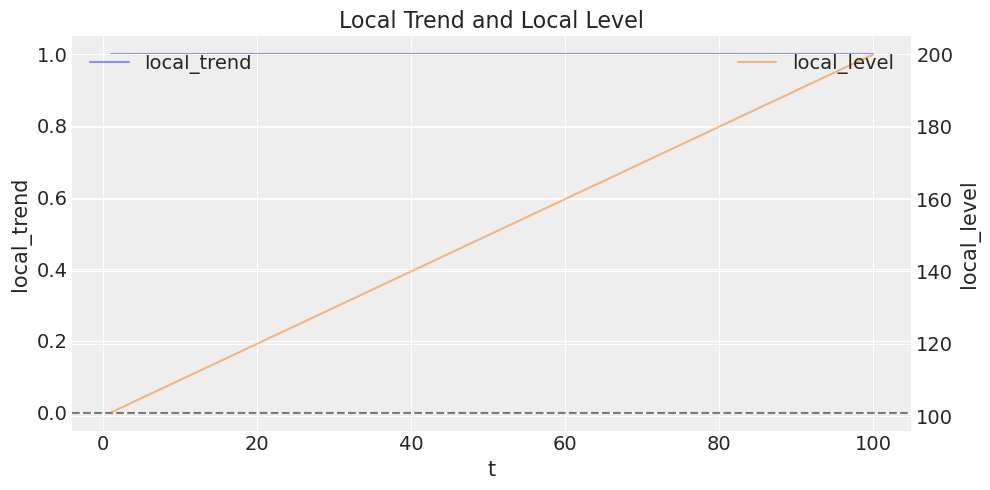

In [7]:
df_deterministic_trend = deterministic_trend(
    rng, 
    N = 100, 
    slope = 1, 
    intercept = 100
    )

plot_stochastic_trend(df_deterministic_trend)

### Cycles

In [8]:
# Dataframe con columna 'fecha' desde 2021-01-01 hasta 2023-11-30, con frecuencia semanal
df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

# Agregamos columna 't' con el número de semana
df["t"] = df.index + 1

# Agregamos el dia de la semana como string
df["dia_semana"] = df["fecha"].dt.day_name()

# Agregamos el dia de la semana como numero
df["dia_semana_num"] = df["fecha"].dt.dayofweek + 1

df.head()

fecha  t dia_semana  dia_semana_num
0 2021-01-01  1     Friday               5
1 2021-01-02  2   Saturday               6
2 2021-01-03  3     Sunday               7
3 2021-01-04  4     Monday               1
4 2021-01-05  5    Tuesday               2

In [9]:
def make_fourier_features(df, date_var_name, n_order=10, period=365.25):
    """
    Generate Fourier features based on a given date variable in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the date variable.
        date_var_name (str): The name of the date variable column in the DataFrame.
        n_order (int, optional): The number of Fourier orders to generate. Defaults to 10.
        period (float, optional): The period of the Fourier series. Defaults to 365.25.

    Returns:
        pandas.DataFrame: A DataFrame containing the Fourier features.
    """
    # Calculate the periods based on the date variable
    periods = (df[date_var_name] - pd.Timestamp("1900-01-01")).dt.days / period

    # Generate the Fourier features using sine and cosine functions
    fourier_features = pd.DataFrame(
        {
            f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )

    return fourier_features

<Axes: xlabel='fecha'>

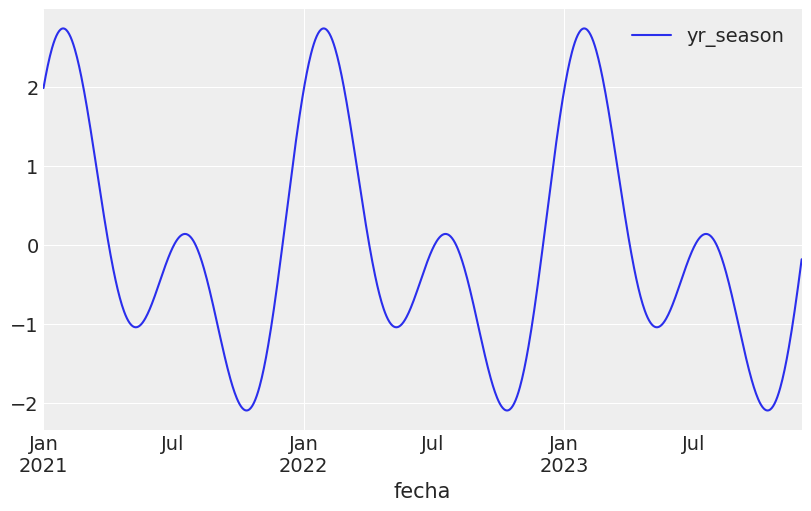

In [10]:
fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)

# genera un numpy array con shape (1, df.shape[0]) yllénalo con valores aleatorios
fourier_coefs = np.array(rng.uniform(0, 1, fourier_features.shape[1]))
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

# Multiplica matricialmente las fourier_features por four_coefs
df['yr_season'] = np.dot(fourier_features, fourier_coefs)

df.plot(x="fecha", y=["yr_season"])


# Modeling

## Trend

In [11]:
df = df_stoch_trend.assign(y = lambda x: x.local_level + rng.normal(0, 1, 100))

In [12]:
df.head()

t  local_trend  local_level           y
0  1    -0.521628   102.402626  103.090206
1  2    -1.095988   100.213918  100.176089
2  3    -3.458094    95.041352   95.357463
3  4    -3.890317    91.306045   90.350359
4  5    -4.609461    86.437916   86.573733

<Axes: xlabel='t'>

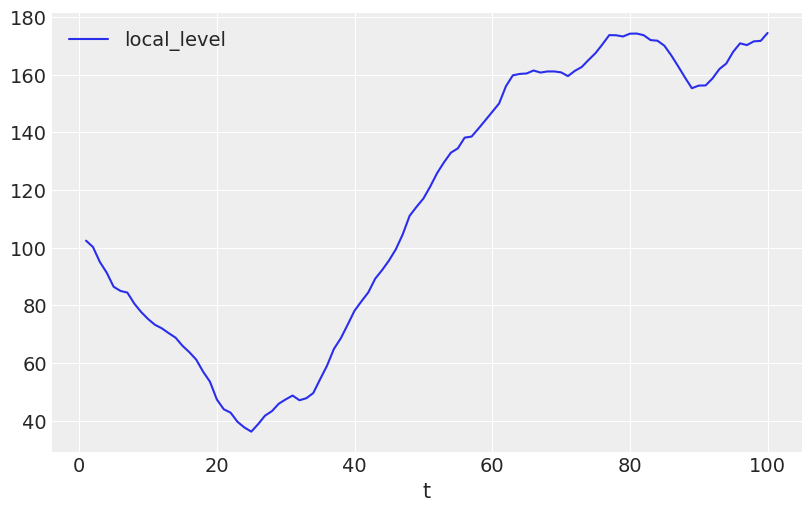

In [13]:
df.plot(x="t", y=["local_level"])

### 0 - Scale the data

In [14]:
t = df["t"].to_numpy()

# Max-min scaling
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [15]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y_min = np.min(y)
y = y / y_max

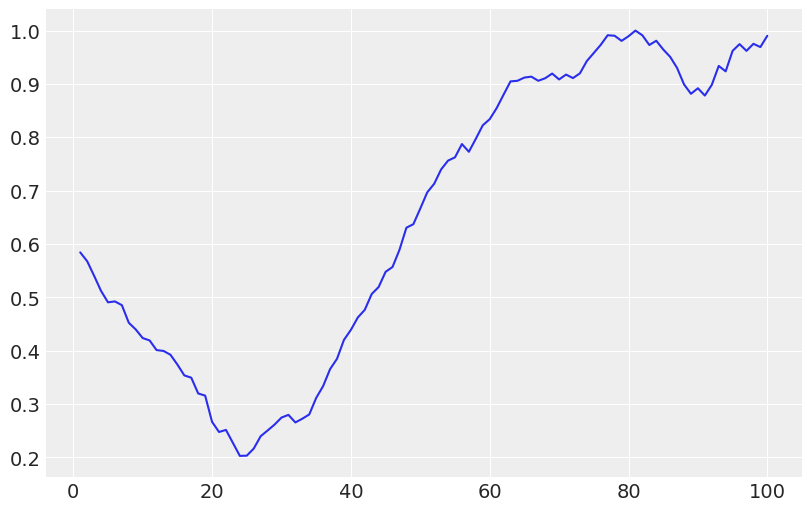

In [16]:
plt.plot(df['t'], y)

### 1 - Model

In [17]:
T = y.shape[0]

sigma_lt_0 = 1 / 4 / T

mu_ll_0 = y[0]
sigma_ll_0 = 0.68 * (1 - y_min/y_max)

sigma_lt = np.std(np.diff(y))
sigma_ll = sigma_lt

sigma_epsilon = np.std(y)

print(f"y_max      = {y_max}")
print(f"y_min      = {y_min}")
print(f"T          = {T}")
print(f"sigma_lt_0 = {sigma_lt_0}")
print(f"mu_ll_0    = {mu_ll_0}")
print(f"sigma_ll_0 = {sigma_ll_0}")
print(f"sigma_lt   = {sigma_lt}, lam_lt = {1 / sigma_lt}")
print(f"sigma_ll   = {sigma_ll}, lam_ll = {1 / sigma_ll}")

print(f"sigma   = {sigma_epsilon}, lam_sigma = {1 / sigma_epsilon}")

y_max      = 176.42042455531433
y_min      = 35.80299421511964
T          = 100
sigma_lt_0 = 0.0025
mu_ll_0    = 0.584343941890953
sigma_ll_0 = 0.5419999009318336
sigma_lt   = 0.019020314279213663, lam_lt = 52.57536680625984
sigma_ll   = 0.019020314279213663, lam_ll = 52.57536680625984
sigma   = 0.27413439784859206, lam_sigma = 3.6478457568550473


In [18]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=False) as stochastic_trend_model:

    # sigma_local_trend = pm.Exponential("sigma_local_trend", lam=y_max * 1)  # 20
    # sigma_local_level = pm.Exponential("sigma_local_level", lam=y_max * 1)  # 20
    # sigma             = pm.Exponential("sigma", lam=y_max * 1)              # .1
    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=1/sigma_lt)  
    sigma_local_level = pm.Exponential("sigma_local_level", lam=1/sigma_ll)  
    sigma             = pm.Exponential("sigma", lam=1/sigma_epsilon)              

    # local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=1e-1)
    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=sigma_lt_0)
    diff_local_trend = pm.Normal("diff_local_trend", mu=0, sigma=sigma_local_trend, dims="n_obs")
    local_trend      = pm.Deterministic("local_trend", diff_local_trend.cumsum() + local_trend_0, dims="n_obs")
    
    # local_level_0    = pm.Normal("local_level_0", mu=0, sigma=.5)
    local_level_0    = pm.Normal("local_level_0", mu=mu_ll_0, sigma=sigma_ll_0)
    diff_local_level = pm.Normal("diff_local_level", mu=local_trend, sigma=sigma_local_level, dims="n_obs")
    local_level      = pm.Deterministic("local_level", diff_local_level.cumsum() + local_level_0, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=local_level, sigma=sigma, dims="n_obs", observed=y)

    stochastic_trend_prior = pm.sample_prior_predictive()

Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y_obs]


In [19]:
stochastic_trend_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

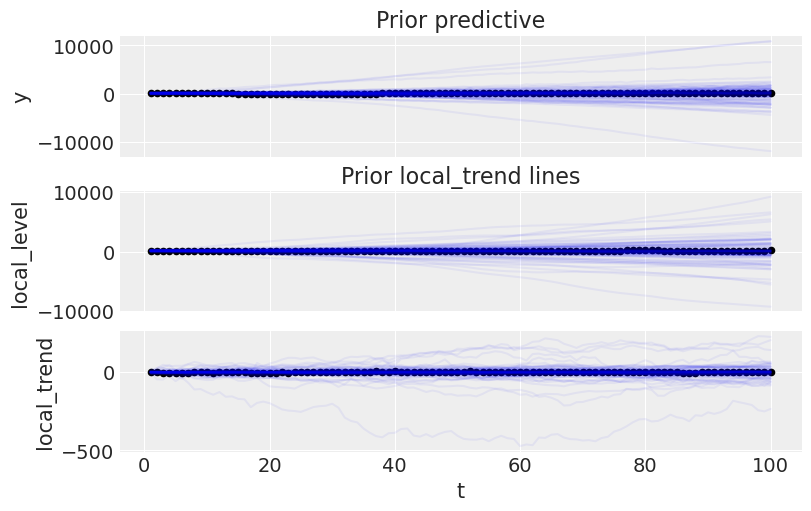

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [21]:
with stochastic_trend_model:
    # inference data, trace, posterior
    idata = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=12000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time = 0:00:03.297102
Sampling...


  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

Sampling time = 0:05:27.968329
Transforming variables...
Transformation time = 0:00:01.995052
Computing Log Likelihood...
Log Likelihood time = 0:00:01.082114
Sampling: [y_obs]


In [22]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [23]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

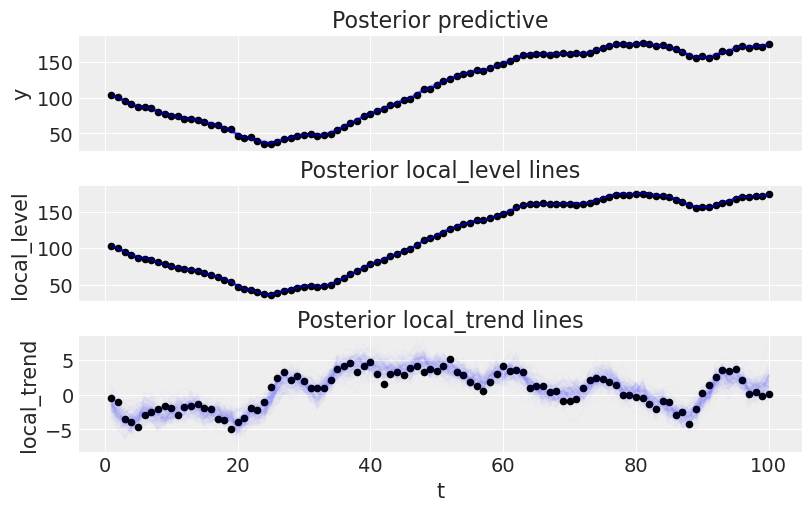

In [24]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

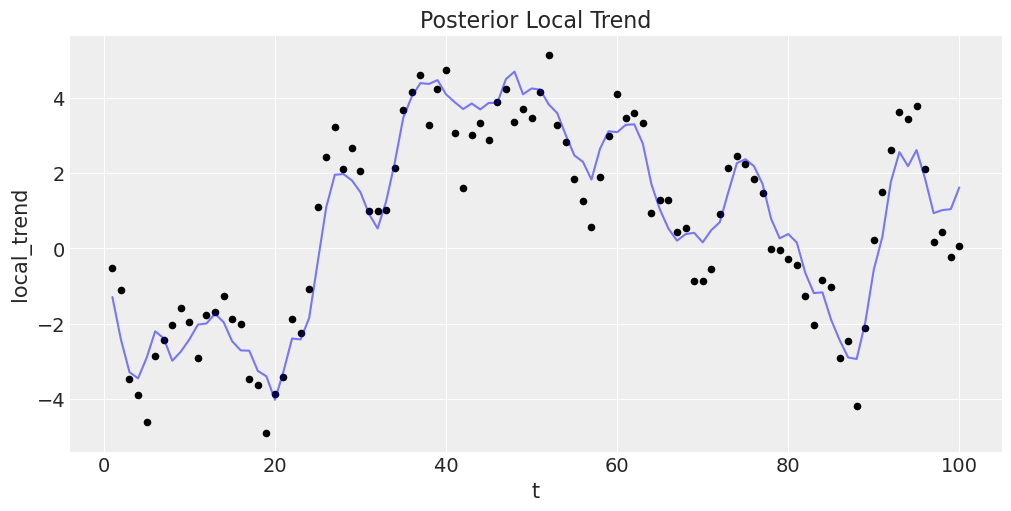

In [25]:
posterior_avg_trend = y_max*idata.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [26]:
az.summary(idata, var_names=['sigma_local_trend', 'sigma_local_level', 'local_trend_0', 'local_level_0', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  0.006  0.001   0.004    0.009        0.0      0.0   
sigma_local_level  0.008  0.004   0.001    0.013        0.0      0.0   
local_trend_0     -0.001  0.002  -0.006    0.004        0.0      0.0   
local_level_0      0.590  0.012   0.568    0.613        0.0      0.0   
sigma              0.005  0.002   0.002    0.008        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
sigma_local_trend     159.0    2139.0   1.03  
sigma_local_level      67.0      81.0   1.06  
local_trend_0       18830.0   33016.0   1.00  
local_level_0        5541.0    8654.0   1.00  
sigma                 142.0     249.0   1.04

In [27]:
az.summary(idata, var_names=['sigma_local_trend', 'sigma_local_level', 'local_trend_0', 'local_level_0', 'sigma'])*y_max

mean        sd      hdi_3%     hdi_97%  mcse_mean  \
sigma_local_trend    1.058523  0.176420    0.705682    1.587784        0.0   
sigma_local_level    1.411363  0.705682    0.176420    2.293466        0.0   
local_trend_0       -0.176420  0.352841   -1.058523    0.705682        0.0   
local_level_0      104.088050  2.117045  100.206801  108.145720        0.0   
sigma                0.882102  0.352841    0.352841    1.411363        0.0   

                   mcse_sd      ess_bulk      ess_tail       r_hat  
sigma_local_trend      0.0  2.805085e+04  3.773633e+05  181.713037  
sigma_local_level      0.0  1.182017e+04  1.429005e+04  187.005650  
local_trend_0          0.0  3.321997e+06  5.824697e+06  176.420425  
local_level_0          0.0  9.775456e+05  1.526742e+06  176.420425  
sigma                  0.0  2.505170e+04  4.392869e+04  183.477242

In [28]:
az.summary(ppc, var_names=['y_obs'])

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_obs[0]   0.583  0.008   0.568    0.598        0.0      0.0   17557.0   
y_obs[1]   0.566  0.007   0.552    0.579        0.0      0.0   13218.0   
y_obs[2]   0.541  0.007   0.527    0.554        0.0      0.0   31693.0   
y_obs[3]   0.514  0.007   0.501    0.529        0.0      0.0    4898.0   
y_obs[4]   0.495  0.007   0.482    0.511        0.0      0.0    2626.0   
...          ...    ...     ...      ...        ...      ...       ...   
y_obs[95]  0.970  0.007   0.955    0.983        0.0      0.0    2423.0   
y_obs[96]  0.966  0.007   0.953    0.981        0.0      0.0    3710.0   
y_obs[97]  0.973  0.007   0.959    0.987        0.0      0.0   21068.0   
y_obs[98]  0.973  0.007   0.960    0.988        0.0      0.0    3296.0   
y_obs[99]  0.988  0.008   0.972    1.002        0.0      0.0   15844.0   

           ess_tail  r_hat  
y_obs[0]    10274.0   1.01  
y_obs[1]    10073.0   1.00  
y_obs[2]    18089.0   1.00  
y_obs[3]     8039.0   1.00  
y_obs[4]     5589.0   1.00  
...             ...    ...  
y_obs[95]    6505.0   1.00  
y_obs[96]    7315.0   1.00  
y_obs[97]   14491.0   1.00  
y_obs[98]    7125.0   1.00  
y_obs[99]   10090.0   1.00  

[100 rows x 9 columns]

### Alternativa que no funciona

In [29]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=True) as stochastic_trend_model_2:

    # Define the standard deviation for the trend, level and signal noises
    sigma_local_trend = pm.HalfNormal('sigma_local_trend', sigma=sigma_lt / np.sqrt(1 - 2 / np.pi))
    sigma_local_level = pm.HalfNormal('sigma_local_level', sigma=sigma_ll / np.sqrt(1 - 2 / np.pi))
    sigma             = pm.HalfNormal('sigma', sigma=sigma_epsilon / np.sqrt(1 - 2 / np.pi))

    # Define the Gaussian Random Walk for the trend
    local_trend = pm.GaussianRandomWalk(
        name  = 'local_trend', 
        sigma = sigma_local_trend, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        )

    # Define the level as the trend plus Gaussian noise
    local_level_0 = pm.GaussianRandomWalk(
        name  = 'local_level_0', 
        # mu    = local_trend, # Este es el que da problemas
        sigma = sigma_local_level, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        ) 
    
    local_level = pm.Deterministic("local_level", local_level_0 + local_trend, dims = "n_obs")
    
    # Likelihood
    y_obs = pm.Normal(
        name     =  "y_obs", 
        mu       = local_level, 
        sigma    = sigma, 
        # dims     = "n_obs", 
        observed = y,
        )
    
    stochastic_trend_prior2 = pm.sample_prior_predictive()


c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Sampling: [local_level_0, local_trend, sigma, sigma_local_level, sigma_local_trend, y_obs]


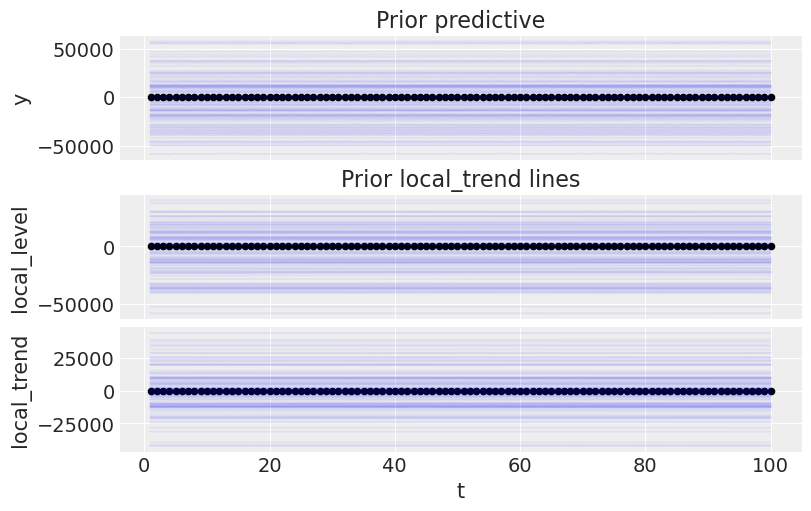

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [31]:
RANDOM_SEED = 99999
rng = np.random.default_rng(RANDOM_SEED)

with stochastic_trend_model_2:
    idata2 = pm.sample(
        return_inferencedata=True, 
        # target_accept=0.9,
        draws=3000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True},
        )
    ppc2 = pm.sample_posterior_predictive(trace=idata2)

Compiling...
Compilation time = 0:00:05.249300
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time = 0:00:43.359410
Transforming variables...
Transformation time = 0:00:00.339914
Computing Log Likelihood...
Log Likelihood time = 0:00:00.413472
Sampling: [y_obs]


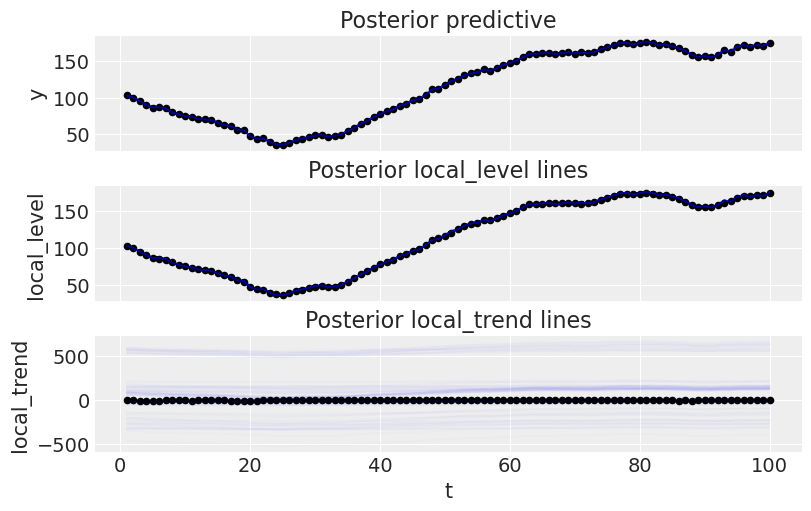

In [32]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc2, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

In [33]:
idata2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

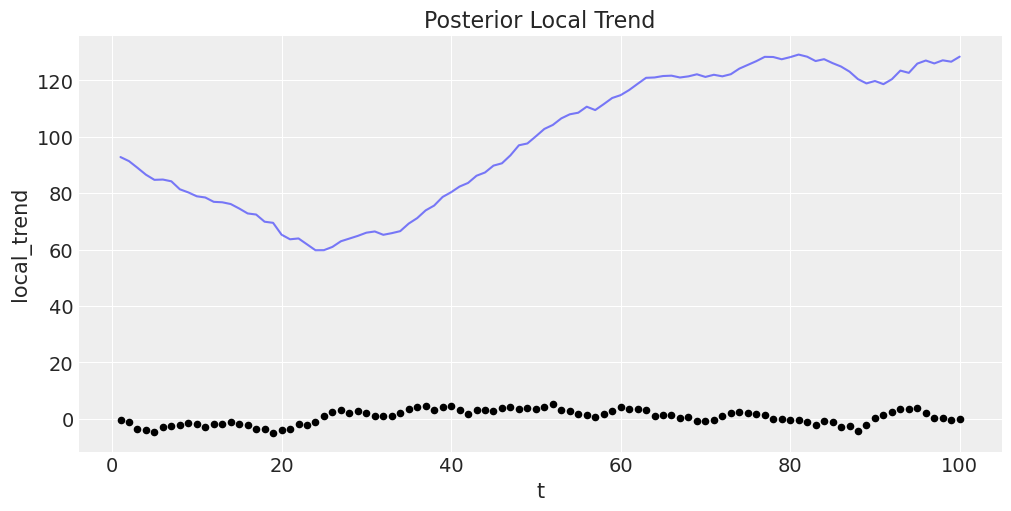

In [34]:
posterior_avg_trend2 = y_max*idata2.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend2

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend2, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [35]:
az.summary(idata2, var_names=['sigma_local_trend', 'sigma_local_level', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  0.013  0.006   0.003    0.021      0.002    0.001   
sigma_local_level  0.013  0.006   0.001    0.021      0.002    0.001   
sigma              0.002  0.001   0.000    0.004      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
sigma_local_trend      12.0      38.0   1.37  
sigma_local_level      11.0      49.0   1.37  
sigma                  43.0      42.0   1.08

In [36]:
az.summary(idata2, var_names=['sigma_local_trend', 'sigma_local_level', 'sigma']) * y_max

mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  2.293466  1.058523  0.529261  3.704829   0.352841  0.17642   
sigma_local_level  2.293466  1.058523  0.176420  3.704829   0.352841  0.17642   
sigma              0.352841  0.176420  0.000000  0.705682   0.000000  0.00000   

                      ess_bulk     ess_tail       r_hat  
sigma_local_trend  2117.045095  6703.976133  241.695982  
sigma_local_level  1940.624670  8644.600803  241.695982  
sigma              7586.078256  7409.657831  190.534059

In [37]:
az.summary(ppc2, var_names=['y_obs'])

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_obs[0]   0.584  0.003   0.578    0.590        0.0      0.0   15285.0   
y_obs[1]   0.568  0.003   0.562    0.573        0.0      0.0   15579.0   
y_obs[2]   0.540  0.003   0.535    0.546        0.0      0.0   14047.0   
y_obs[3]   0.512  0.003   0.506    0.518        0.0      0.0   14971.0   
y_obs[4]   0.491  0.003   0.485    0.496        0.0      0.0   14109.0   
...          ...    ...     ...      ...        ...      ...       ...   
y_obs[95]  0.974  0.003   0.968    0.980        0.0      0.0   14394.0   
y_obs[96]  0.962  0.003   0.957    0.968        0.0      0.0   14403.0   
y_obs[97]  0.975  0.003   0.969    0.981        0.0      0.0   13799.0   
y_obs[98]  0.969  0.003   0.964    0.976        0.0      0.0   13905.0   
y_obs[99]  0.990  0.003   0.985    0.996        0.0      0.0   15347.0   

           ess_tail  r_hat  
y_obs[0]     2182.0   1.03  
y_obs[1]     1912.0   1.03  
y_obs[2]     1972.0   1.03  
y_obs[3]     2295.0   1.02  
y_obs[4]     2004.0   1.03  
...             ...    ...  
y_obs[95]    1737.0   1.03  
y_obs[96]    2033.0   1.02  
y_obs[97]    1477.0   1.03  
y_obs[98]    1750.0   1.03  
y_obs[99]    2065.0   1.03  

[100 rows x 9 columns]

## Seasonality

In [38]:
df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

df = pd.concat([df, fourier_features], axis = 1)
df['yr_season'] = np.dot(fourier_features, fourier_coefs)
df['y'] = df['yr_season'] + rng.normal(0, 1, df.shape[0])
df.head()

fecha  sin_order_1  cos_order_1  sin_order_2  cos_order_2  yr_season  \
0 2021-01-01    -0.004301     0.999991    -0.008601     0.999963   1.987052   
1 2021-01-02     0.012901     0.999917     0.025801     0.999667   2.038286   
2 2021-01-03     0.030100     0.999547     0.060172     0.998188   2.088007   
3 2021-01-04     0.047289     0.998881     0.094472     0.995527   2.136170   
4 2021-01-05     0.064464     0.997920     0.128661     0.991689   2.182734   

          y  
0  1.506895  
1  2.299883  
2  2.658444  
3  2.501905  
4  3.065784

<Axes: xlabel='fecha'>

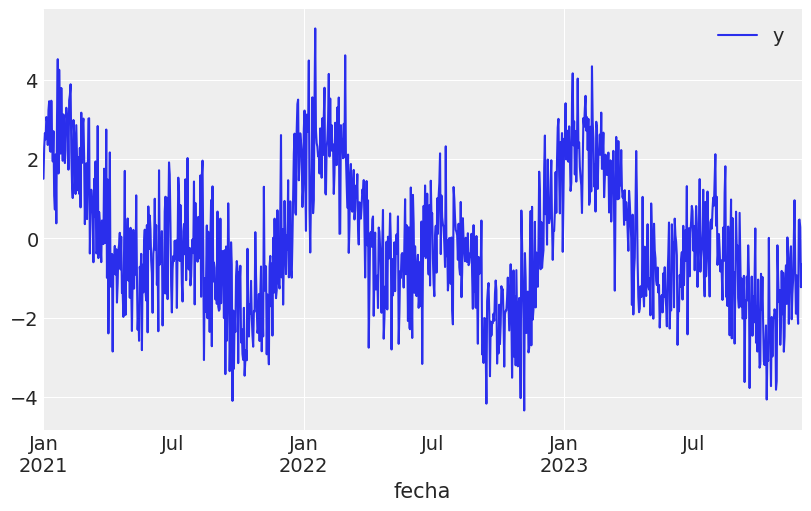

In [39]:
df.plot("fecha", "y")

### 0 - Scale the data

In [40]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

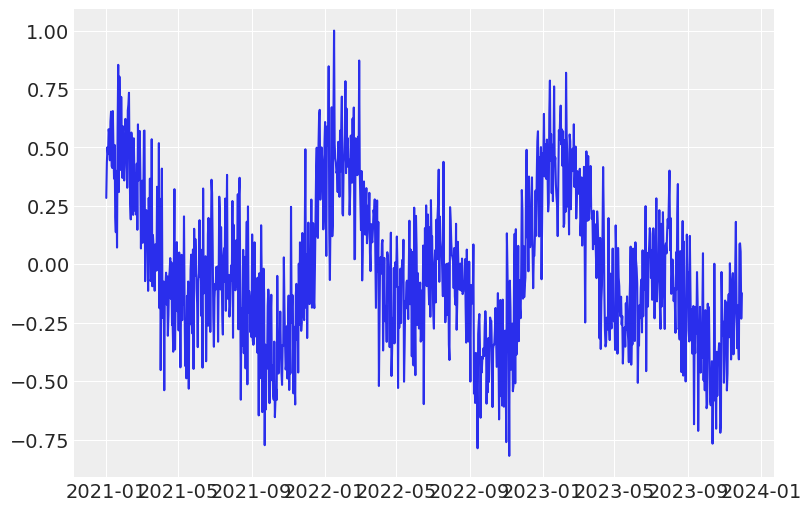

In [41]:
plt.plot(df['fecha'], y)

### 1 - Model

In [42]:
n_order = 2

coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(check_bounds=False, coords=coords) as seasonality_model:
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=0.5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )
    
    y_obs = pm.Normal("y_obs", mu=seasonality, sigma=sigma, observed=y, dims = "n_obs")

    seasonality_model_prior = pm.sample_prior_predictive()

Sampling: [beta_fourier, sigma, y_obs]


In [43]:
seasonality_model_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

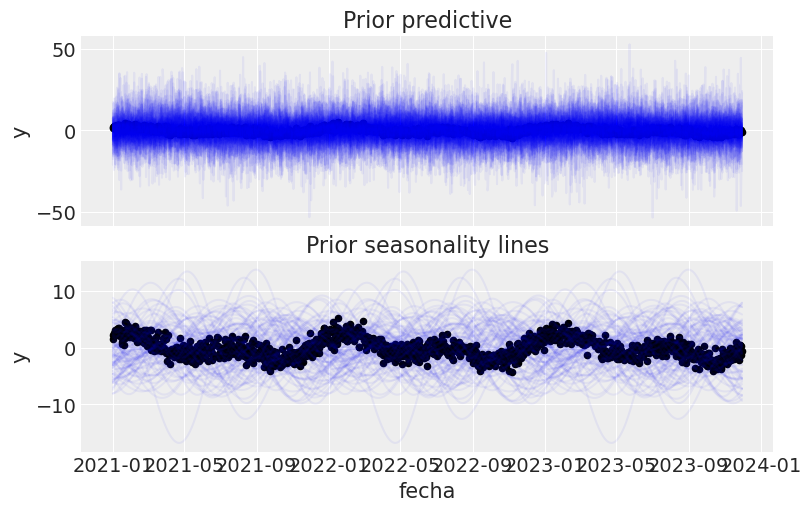

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(seasonality_model_prior, group="prior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(seasonality_model_prior, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Prior seasonality lines");

In [45]:
with seasonality_model:
    # inference data, trace, posterior
    idata_s = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=12000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc_s = pm.sample_posterior_predictive(trace=idata_s)

Compiling...
Compilation time = 0:00:02.391487
Sampling...


  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

Sampling time = 0:00:04.502182
Transforming variables...
Transformation time = 0:00:00.830060
Computing Log Likelihood...
Log Likelihood time = 0:00:01.153203
Sampling: [y_obs]


In [46]:
idata_s

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [47]:
ppc_s

Inference data with groups:
	> posterior_predictive
	> observed_data

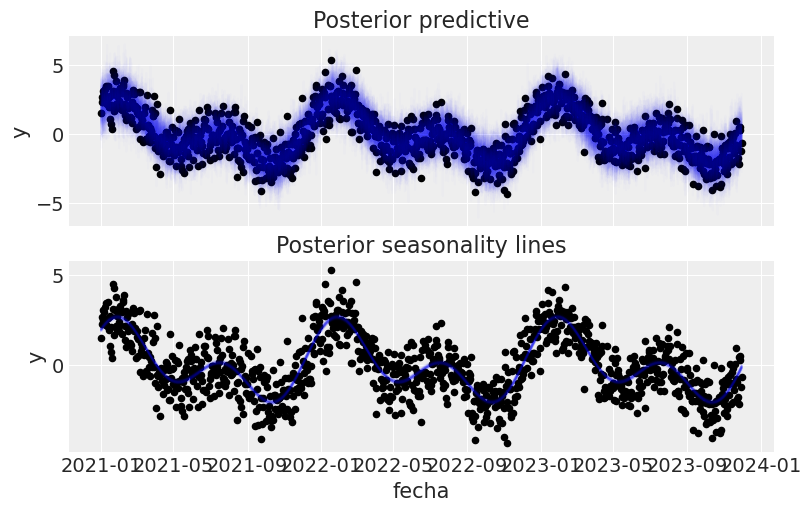

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(ppc_s, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_s, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior seasonality lines");

In [49]:
az.summary(idata_s, var_names=['beta_fourier', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_fourier[0]  0.190  0.008   0.174    0.205        0.0      0.0   78752.0   
beta_fourier[1]  0.185  0.008   0.169    0.201        0.0      0.0   79518.0   
beta_fourier[2]  0.173  0.008   0.157    0.188        0.0      0.0   81761.0   
beta_fourier[3]  0.188  0.008   0.173    0.204        0.0      0.0   76914.0   
sigma            0.191  0.004   0.183    0.199        0.0      0.0   75082.0   

                 ess_tail  r_hat  
beta_fourier[0]   45632.0    1.0  
beta_fourier[1]   48105.0    1.0  
beta_fourier[2]   44964.0    1.0  
beta_fourier[3]   46049.0    1.0  
sigma             43844.0    1.0

In [50]:
az.summary(idata_s, var_names=['beta_fourier', 'sigma'])*y_max

mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta_fourier[0]  1.007964  0.042441  0.923082  1.087540        0.0      0.0   
beta_fourier[1]  0.981438  0.042441  0.896557  1.066319        0.0      0.0   
beta_fourier[2]  0.917777  0.042441  0.832896  0.997353        0.0      0.0   
beta_fourier[3]  0.997353  0.042441  0.917777  1.082235        0.0      0.0   
sigma            1.013269  0.021220  0.970828  1.055709        0.0      0.0   

                      ess_bulk       ess_tail     r_hat  
beta_fourier[0]  417784.962485  242081.006300  5.305071  
beta_fourier[1]  421848.646979  255200.447231  5.305071  
beta_fourier[2]  433747.921548  238537.218778  5.305071  
beta_fourier[3]  408034.241728  244293.220966  5.305071  
sigma            398315.351398  232595.539100  5.305071

In [51]:
res = az.summary(ppc_s, var_names=['y_obs'])

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


In [52]:
res

mean     sd  hdi_3%  hdi_97%  \
y_obs[2021-01-01T00:00:00.000000000]  0.371  0.192   0.014    0.736   
y_obs[2021-01-02T00:00:00.000000000]  0.381  0.191   0.019    0.735   
y_obs[2021-01-03T00:00:00.000000000]  0.389  0.192   0.026    0.750   
y_obs[2021-01-04T00:00:00.000000000]  0.399  0.191   0.036    0.755   
y_obs[2021-01-05T00:00:00.000000000]  0.405  0.192   0.046    0.769   
...                                     ...    ...     ...      ...   
y_obs[2023-11-26T00:00:00.000000000] -0.074  0.192  -0.434    0.291   
y_obs[2023-11-27T00:00:00.000000000] -0.061  0.191  -0.422    0.297   
y_obs[2023-11-28T00:00:00.000000000] -0.049  0.191  -0.405    0.314   
y_obs[2023-11-29T00:00:00.000000000] -0.037  0.191  -0.396    0.323   
y_obs[2023-11-30T00:00:00.000000000] -0.023  0.192  -0.381    0.336   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
y_obs[2021-01-01T00:00:00.000000000]      0.001    0.001   59307.0   57955.0   
y_obs[2021-01-02T00:00:00.000000000]      0.001    0.001   60160.0   59726.0   
y_obs[2021-01-03T00:00:00.000000000]      0.001    0.001   59939.0   60397.0   
y_obs[2021-01-04T00:00:00.000000000]      0.001    0.001   57537.0   59175.0   
y_obs[2021-01-05T00:00:00.000000000]      0.001    0.001   59820.0   59389.0   
...                                         ...      ...       ...       ...   
y_obs[2023-11-26T00:00:00.000000000]      0.001    0.001   60661.0   58635.0   
y_obs[2023-11-27T00:00:00.000000000]      0.001    0.001   58796.0   58176.0   
y_obs[2023-11-28T00:00:00.000000000]      0.001    0.001   59430.0   57953.0   
y_obs[2023-11-29T00:00:00.000000000]      0.001    0.001   59159.0   59585.0   
y_obs[2023-11-30T00:00:00.000000000]      0.001    0.001   60117.0   59335.0   

                                      r_hat  
y_obs[2021-01-01T00:00:00.000000000]    1.0  
y_obs[2021-01-02T00:00:00.000000000]    1.0  
y_obs[2021-01-03T00:00:00.000000000]    1.0  
y_obs[2021-01-04T00:00:00.000000000]    1.0  
y_obs[2021-01-05T00:00:00.000000000]    1.0  
...                                     ...  
y_obs[2023-11-26T00:00:00.000000000]    1.0  
y_obs[2023-11-27T00:00:00.000000000]    1.0  
y_obs[2023-11-28T00:00:00.000000000]    1.0  
y_obs[2023-11-29T00:00:00.000000000]    1.0  
y_obs[2023-11-30T00:00:00.000000000]    1.0  

[1064 rows x 9 columns]

In [53]:
res['mean']*y_max

y_obs[2021-01-01T00:00:00.000000000]    1.968181
y_obs[2021-01-02T00:00:00.000000000]    2.021232
y_obs[2021-01-03T00:00:00.000000000]    2.063673
y_obs[2021-01-04T00:00:00.000000000]    2.116723
y_obs[2021-01-05T00:00:00.000000000]    2.148554
                                          ...   
y_obs[2023-11-26T00:00:00.000000000]   -0.392575
y_obs[2023-11-27T00:00:00.000000000]   -0.323609
y_obs[2023-11-28T00:00:00.000000000]   -0.259948
y_obs[2023-11-29T00:00:00.000000000]   -0.196288
y_obs[2023-11-30T00:00:00.000000000]   -0.122017
Name: mean, Length: 1064, dtype: float64

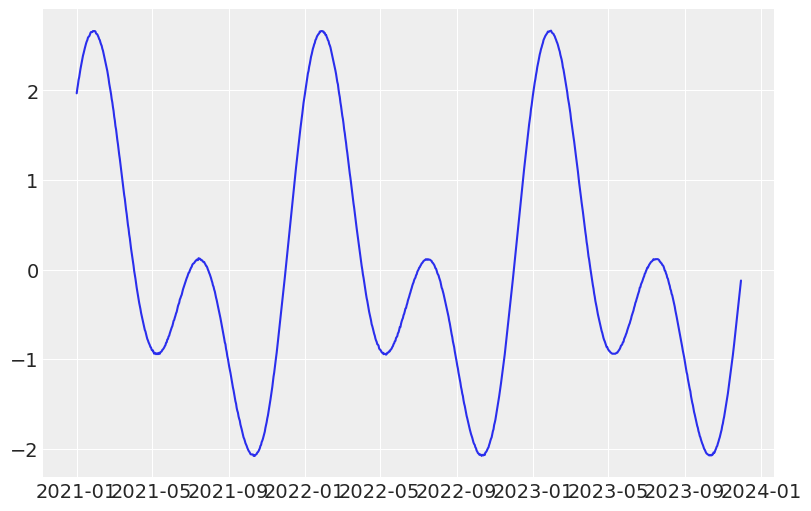

In [54]:
plt.plot(df["fecha"], res['mean']*y_max)

## Trend + Season

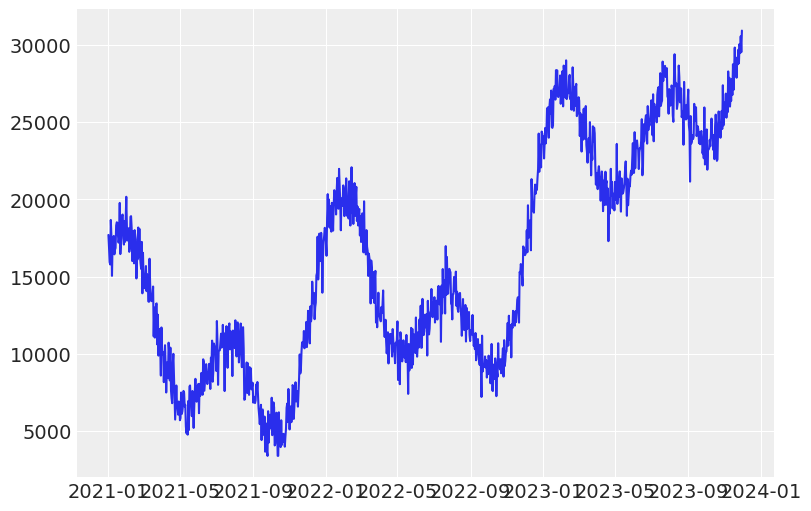

In [55]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

df = pd.concat([
    df, 
    stochastic_trend(
        rng, 
        N = df.shape[0], 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 10000
        )
    ], 
               axis = 1)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

k =(df['local_level'].max() - df['local_level'].min()) * 0.2 / np.sqrt(2)

df['yr_season'] = k * np.dot(fourier_features, fourier_coefs)

df['y'] = df['local_level'] + df['yr_season'] + rng.normal(0, 1000, df.shape[0])

plt.plot(df["fecha"], df['y'])

In [56]:
df

fecha     t  local_trend   local_level    yr_season             y
0    2021-01-01     1    -0.521628   9999.398528  6000.890582  17703.966532
1    2021-01-02     2    -1.095988   9998.214240  6155.617229  16921.948122
2    2021-01-03     3    -3.458094   9995.419512  6305.773326  15943.153879
3    2021-01-04     4    -3.890317   9991.485024  6451.226263  15791.287858
4    2021-01-05     5    -4.609461   9986.525422  6591.848180  18674.780989
...         ...   ...          ...           ...          ...           ...
1059 2023-11-26  1060    29.593822  31168.834477 -1367.256294  30071.281075
1060 2023-11-27  1061    30.075970  31199.439153 -1163.720809  29479.490263
1061 2023-11-28  1062    30.314250  31230.267329  -958.181115  30570.542377
1062 2023-11-29  1063    29.727088  31261.563491  -750.816262  29539.749522
1063 2023-11-30  1064    30.602816  31292.005876  -541.807664  30937.814035

[1064 rows x 6 columns]

In [57]:
# STL decomposition
from statsmodels.tsa.seasonal import STL


In [58]:
aux = df[['fecha', 'y']].copy()
aux.set_index('fecha', inplace=True, drop = True)
# The decomposition requires 1 input, the data series. If the data series does 
# not have a frequency, then you must also specify period. The default value for 
# seasonal is 7, and so should also be changed in most applications.
aux = aux.asfreq('D')


c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


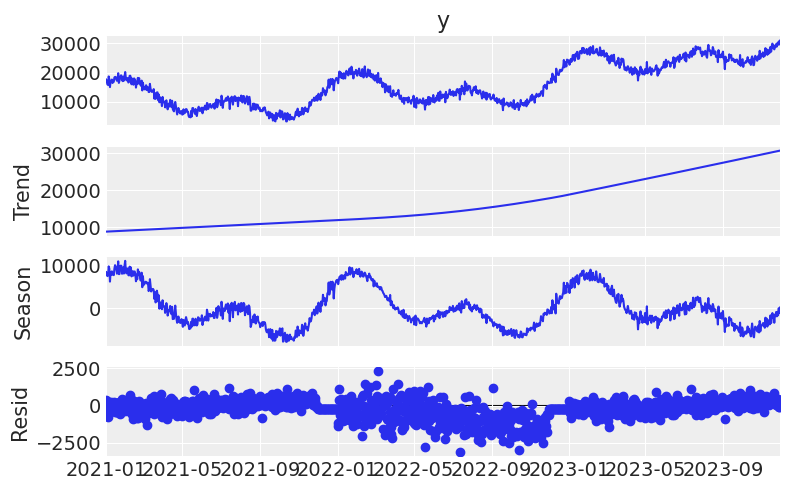

In [59]:
stl = STL(aux['y'], period=365)
res = stl.fit()
fig = res.plot()

### 0 - Scale the data

In [60]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y_min = np.min(y)
y = y / y_max

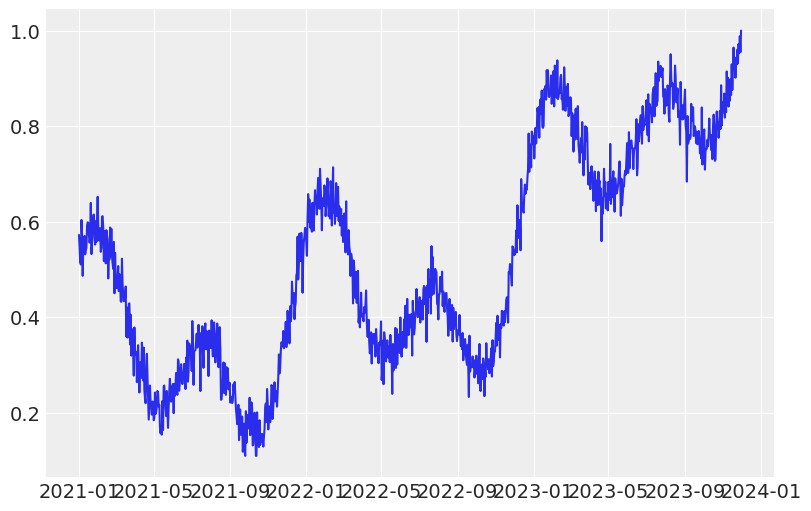

In [61]:
plt.plot(df["fecha"], y)

### 1 - Model

In [62]:
T = y.shape[0]

sigma_lt_0 = 1 / 4 / T

mu_ll_0 = y[0]
sigma_ll_0 = 0.68 * (1 - y_min/y_max)

sigma_lt = np.std(np.diff(y))
sigma_ll = sigma_lt

sigma_epsilon = np.std(y)

print(f"y_max      = {y_max}")
print(f"y_min      = {y_min}")
print(f"T          = {T}")
print(f"sigma_lt_0 = {sigma_lt_0}")
print(f"mu_ll_0    = {mu_ll_0}")
print(f"sigma_ll_0 = {sigma_ll_0}")
print(f"sigma_lt   = {sigma_lt}, lam_lt = {1 / sigma_lt}")
print(f"sigma_ll   = {sigma_ll}, lam_ll = {1 / sigma_ll}")

print(f"sigma   = {sigma_epsilon}, lam_sigma = {1 / sigma_epsilon}")

y_max      = 30937.814035261017
y_min      = 3396.129482500577
T          = 1064
sigma_lt_0 = 0.00023496240601503758
mu_ll_0    = 0.572243614624904
sigma_ll_0 = 0.6053545177604237
sigma_lt   = 0.045195766789900414, lam_lt = 22.125966014663636
sigma_ll   = 0.045195766789900414, lam_ll = 22.125966014663636
sigma   = 0.2279012361694637, lam_sigma = 4.387865624635823


In [63]:
n_order = 2

coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(coords=coords, check_bounds=False) as trend_season_model:

    # sigma_local_trend = pm.Exponential("sigma_local_trend", lam=y_max * 1)  # 20
    # sigma_local_level = pm.Exponential("sigma_local_level", lam=y_max * 1)  # 20
    # sigma             = pm.Exponential("sigma", lam=y_max * 1)              # .1
    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=1/sigma_lt)
    sigma_local_level = pm.Exponential("sigma_local_level", lam=1/sigma_ll)  
    sigma             = pm.Exponential("sigma", lam=1/sigma_epsilon)              

    # local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=1e-1)
    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=sigma_lt_0)
    diff_local_trend = pm.Normal("diff_local_trend", mu=0, sigma=sigma_local_trend, dims="n_obs")
    local_trend      = pm.Deterministic("local_trend", diff_local_trend.cumsum() + local_trend_0, dims="n_obs")
    
    # local_level_0    = pm.Normal("local_level_0", mu=0, sigma=.5)
    local_level_0    = pm.Normal("local_level_0", mu=mu_ll_0, sigma=sigma_ll_0)
    diff_local_level = pm.Normal("diff_local_level", mu=local_trend, sigma=sigma_local_level, dims="n_obs")
    local_level      = pm.Deterministic("local_level", diff_local_level.cumsum() + local_level_0, dims="n_obs")
    
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=.5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )
    
    mu = pm.Deterministic("mu", local_level + seasonality, dims = "n_obs")

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, dims="n_obs", observed=y)

    trend_season_prior = pm.sample_prior_predictive()

Sampling: [beta_fourier, diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y_obs]


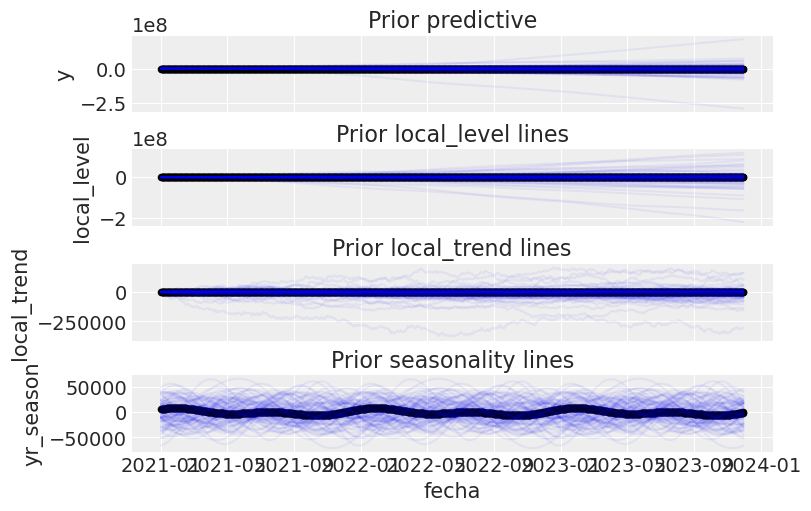

In [64]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior_predictive", num_samples=100)["y_obs"]* y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Prior local_trend lines");


ax[3].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[3])
ax[3].set_title("Prior seasonality lines");

In [65]:
with trend_season_model:
    # inference data, trace, posterior
    idata_s_t = pm.sample(
        return_inferencedata=True, 
        # target_accept=0.9,
        draws=1000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc_s_t = pm.sample_posterior_predictive(trace=idata_s_t)

Compiling...
Compilation time = 0:00:04.590686
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:11:50.564949
Transforming variables...
Transformation time = 0:00:02.420734
Computing Log Likelihood...
Log Likelihood time = 0:00:01.649450
Sampling: [y_obs]


In [66]:
idata_s_t

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [67]:
ppc_s_t

Inference data with groups:
	> posterior_predictive
	> observed_data

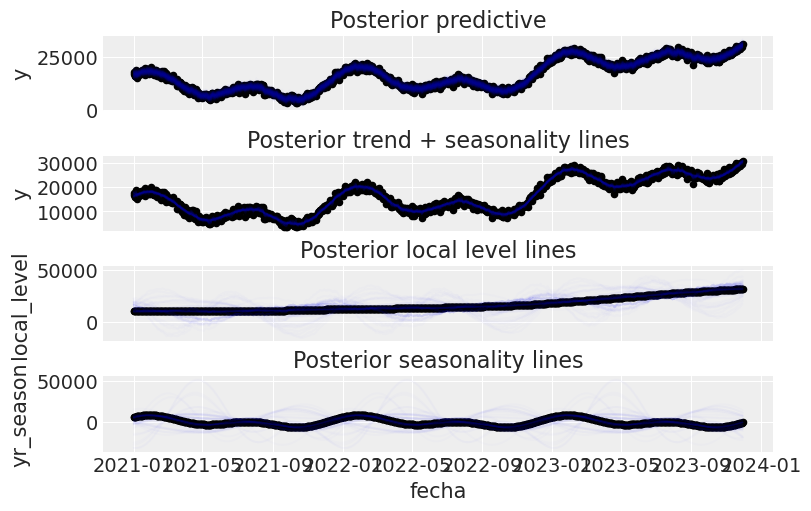

In [68]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(ppc_s_t, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["mu"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend + seasonality lines");

ax[2].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[2])
ax[2].set_title("Posterior local level lines");

ax[3].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[3])
ax[3].set_title("Posterior seasonality lines");

In [71]:
az.summary(idata_s_t, var_names=['~mu', "~seasonality", "~diff_local_trend", "~diff_local_level", "~local_level", "~local_trend"])*y_max

mean           sd        hdi_3%       hdi_97%  \
local_trend_0         -0.000000     0.000000     -0.000000      0.000000   
local_level_0      13829.202874  6991.945972   3774.413312  23698.365551   
beta_fourier[0]     3248.470474  6249.438435 -15159.528877  11354.177751   
beta_fourier[1]     1856.268842  3186.594846  -3465.035172   8105.707277   
beta_fourier[2]     2475.025123  3681.599870  -6032.873737   7796.329137   
beta_fourier[3]     1268.450375  4485.983035  -9033.841698   4207.542709   
sigma_local_trend     30.937814    92.813442      0.000000     61.875628   
sigma_local_level    278.440326   216.564698     61.875628    495.005025   
sigma                959.072235    61.875628    866.258793   1020.947863   

                     mcse_mean      mcse_sd      ess_bulk      ess_tail  \
local_trend_0         0.000000     0.000000  1.206575e+06  1.927426e+07   
local_level_0      2567.838565  1887.206656  1.856269e+05  4.021916e+05   
beta_fourier[0]    2505.962937  1856.268842  2.165647e+05  3.403160e+05   
beta_fourier[1]    1237.512561   928.134421  2.165647e+05  3.403160e+05   
beta_fourier[2]    1237.512561   897.196607  1.856269e+05  3.403160e+05   
beta_fourier[3]    1392.201632  1020.947863  2.784403e+05  7.115697e+05   
sigma_local_trend     0.000000     0.000000  2.165647e+05  7.425075e+05   
sigma_local_level    92.813442    61.875628  1.856269e+05  6.806319e+05   
sigma                30.937814    30.937814  2.165647e+05  6.806319e+05   

                          r_hat  
local_trend_0      33722.217298  
local_level_0      67753.812737  
beta_fourier[0]    57234.955965  
beta_fourier[1]    57234.955965  
beta_fourier[2]    68681.947158  
beta_fourier[3]    57853.712246  
sigma_local_trend  64041.275053  
sigma_local_level  80747.694632  
sigma              57234.955965

## 2 - Prophet-like

### 0 - Scale the data

In [72]:
df

fecha     t  local_trend   local_level    yr_season             y
0    2021-01-01     1    -0.521628   9999.398528  6000.890582  17703.966532
1    2021-01-02     2    -1.095988   9998.214240  6155.617229  16921.948122
2    2021-01-03     3    -3.458094   9995.419512  6305.773326  15943.153879
3    2021-01-04     4    -3.890317   9991.485024  6451.226263  15791.287858
4    2021-01-05     5    -4.609461   9986.525422  6591.848180  18674.780989
...         ...   ...          ...           ...          ...           ...
1059 2023-11-26  1060    29.593822  31168.834477 -1367.256294  30071.281075
1060 2023-11-27  1061    30.075970  31199.439153 -1163.720809  29479.490263
1061 2023-11-28  1062    30.314250  31230.267329  -958.181115  30570.542377
1062 2023-11-29  1063    29.727088  31261.563491  -750.816262  29539.749522
1063 2023-11-30  1064    30.602816  31292.005876  -541.807664  30937.814035

[1064 rows x 6 columns]

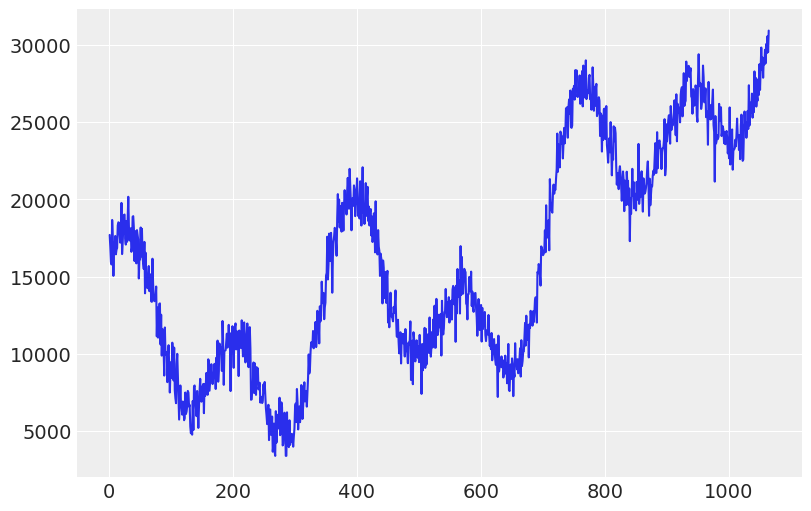

In [73]:
plt.plot(df['t'], df['y'])

In [74]:
# Max-min scaling
# 
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

t = df['t']
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

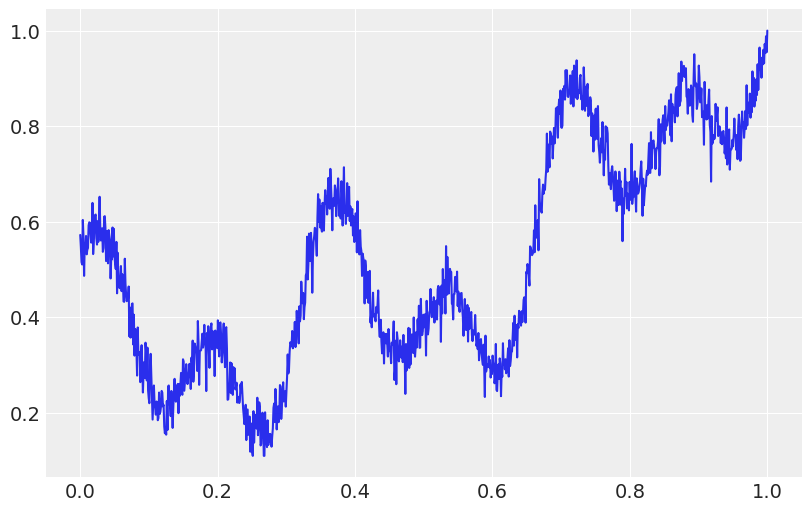

In [75]:
plt.plot(t, y)

### 1 - Model

In [76]:
coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    
    X_data = pm.MutableData('X_data', t)
    y_data = pm.MutableData('y_data', y)

    alpha = pm.HalfNormal("alpha", sigma=2)
    beta  = pm.Normal("beta",  mu=0, sigma=1)
    k     = pm.Uniform("k", lower=0.1, upper=4) 
    sigma = pm.HalfNormal("sigma", sigma = 5)

    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=1, dims="fourier_features")

    seasonality = pm.Deterministic(
        "seasonality", 
        pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )

    trend = pm.Deterministic("trend", alpha + beta * (X_data**k), dims="n_obs")
    # mu = pm.Deterministic("mu", trend * (1 + seasonality), dims="n_obs")
    mu = pm.Deterministic("mu", trend + seasonality, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    prior_pc = pm.sample_prior_predictive()

Sampling: [alpha, beta, beta_fourier, k, sigma, y_obs]


In [248]:
prior_pc

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [249]:
az.extract(prior_pc, group="prior", num_samples=100)["beta"].mean() *y_max

<xarray.DataArray 'beta' ()>
array(3810.68009986)

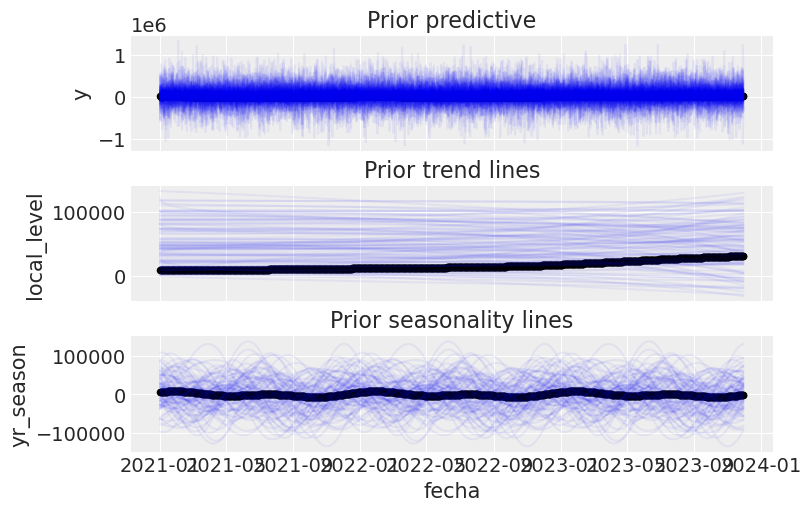

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(prior_pc, group="prior_predictive", num_samples=100)["y_obs"]* y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(prior_pc, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

ax[2].plot(
    df["fecha"],
    az.extract(prior_pc, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[2])
ax[2].set_title("Prior seasonality lines");


In [78]:
with linear_with_seasonality:
    # inference data, trace, posterior
    idata_l_s = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=10000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    posterior_pc_l_s = pm.sample_posterior_predictive(trace=idata_l_s)

Compiling...
Compilation time = 0:00:06.696873
Sampling...


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

Sampling time = 0:00:15.771868
Transforming variables...
Transformation time = 0:00:06.067660
Computing Log Likelihood...
Log Likelihood time = 0:00:08.814908
Sampling: [y_obs]


In [273]:
idata_l_s

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [274]:
posterior_pc_l_s

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

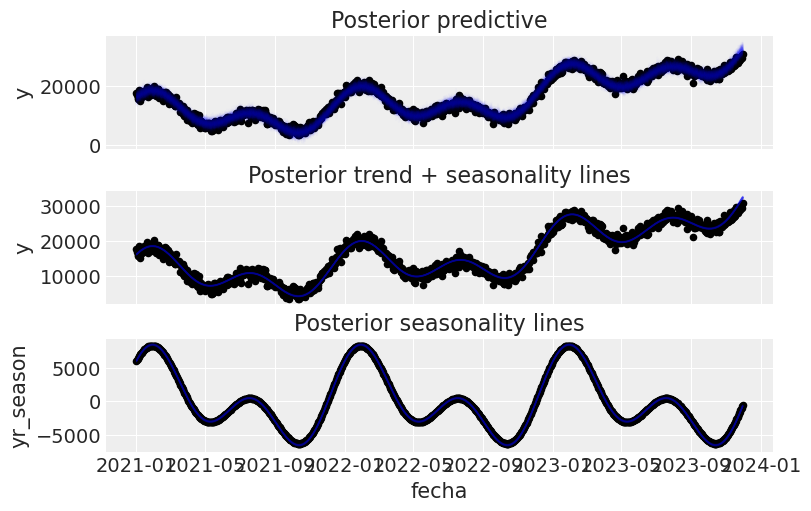

In [79]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(posterior_pc_l_s, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["mu"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend + seasonality lines");

ax[2].plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[2])
ax[2].set_title("Posterior seasonality lines");


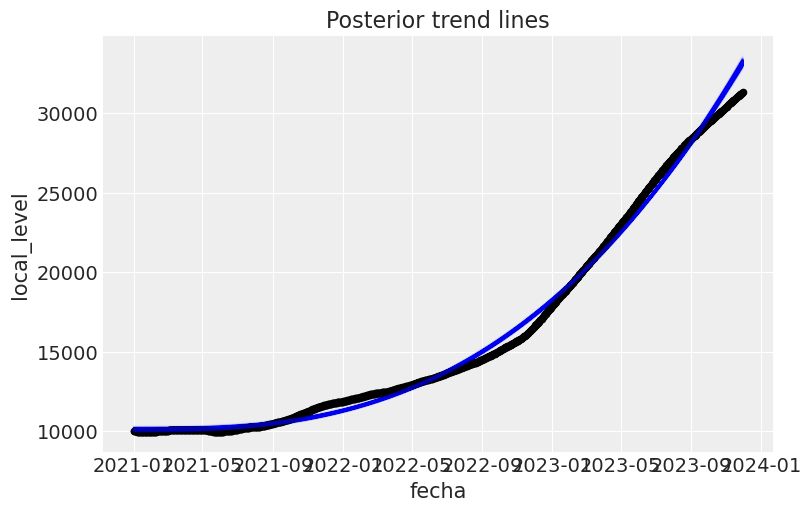

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=1000)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax)
ax.set_title("Posterior trend lines");

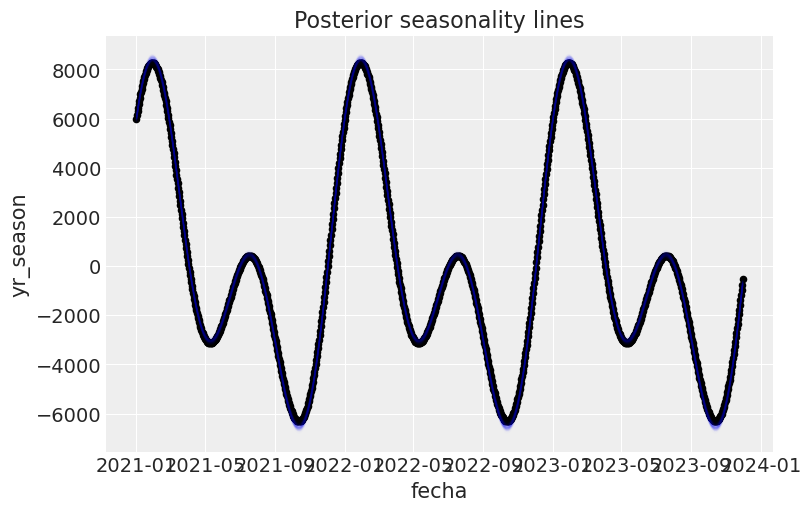

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax)
ax.set_title("Posterior seasonality lines");

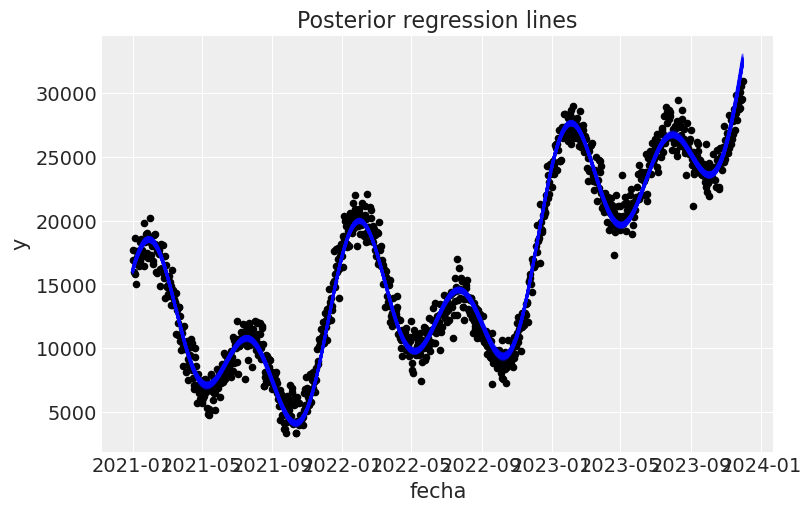

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(idata_l_s, group="posterior", num_samples=100)["mu"] * y_max,
    color="blue",
    alpha=0.5,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax)
ax.set_title("Posterior regression lines");

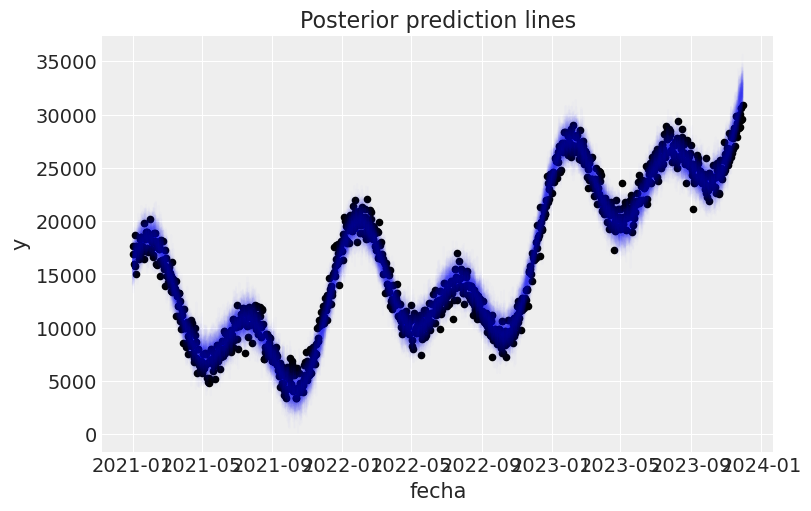

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df["fecha"],
    az.extract(posterior_pc_l_s, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax)
ax.set_title("Posterior prediction lines");

In [84]:
az.summary(idata_l_s, var_names=['~mu', "~seasonality", "~trend", "~k", ], kind = "stats")*y_max

mean          sd        hdi_3%       hdi_97%
beta             23048.671456  123.751256  22801.168944  23296.173969
beta_fourier[0]   3186.594846   61.875628   3093.781404   3279.408288
beta_fourier[1]   3000.967961   61.875628   2908.154519   3093.781404
beta_fourier[2]   3093.781404   61.875628   3000.967961   3186.594846
beta_fourier[3]   3062.843589   61.875628   2970.030147   3155.657032
alpha            10116.665190   61.875628   9992.913933  10240.416446
sigma             1082.823491   30.937814   1051.885677   1144.699119

In [85]:
az.summary(idata_l_s, var_names=['~mu', "~seasonality", "~trend", "~k", ], kind = "diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
beta                   0.0      0.0   26950.0   31460.0    1.0
beta_fourier[0]        0.0      0.0   72476.0   38015.0    1.0
beta_fourier[1]        0.0      0.0   93795.0   37595.0    1.0
beta_fourier[2]        0.0      0.0   90217.0   36515.0    1.0
beta_fourier[3]        0.0      0.0   85726.0   36156.0    1.0
alpha                  0.0      0.0   20571.0   26751.0    1.0
sigma                  0.0      0.0   23447.0   28351.0    1.0

In [86]:
az.summary(idata_l_s, var_names=['k', ])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
k  2.78  0.034   2.716    2.843        0.0      0.0   18777.0   25448.0    1.0

# Probatinas

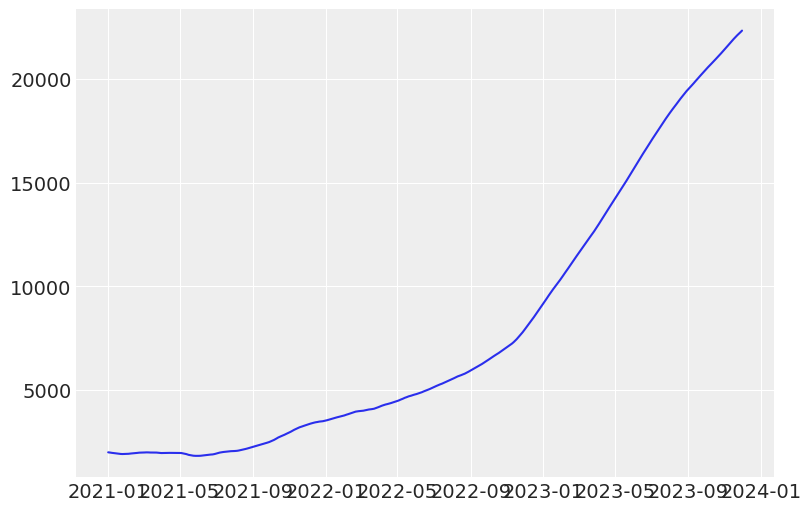

In [159]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

df = pd.concat([
    df, 
    stochastic_trend(
        rng, 
        N = df.shape[0], 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 1000
        )
    ], 
               axis = 1)

plt.plot(df['fecha'], df['local_level'])

In [155]:
df

fecha     t  local_trend  local_level
0    2021-01-01     1     0.847837  2000.767994
1    2021-01-02     2     0.790401  2001.470094
2    2021-01-03     3     0.554191  2002.687651
3    2021-01-04     4     0.510968  2003.154449
4    2021-01-05     5     0.439054  2003.243361
...         ...   ...          ...          ...
1059 2023-11-26  1060     3.859382  5097.729504
1060 2023-11-27  1061     3.907597  5102.165807
1061 2023-11-28  1062     3.931425  5106.611158
1062 2023-11-29  1063     3.872709  5112.052941
1063 2023-11-30  1064     3.960282  5115.852792

[1064 rows x 4 columns]

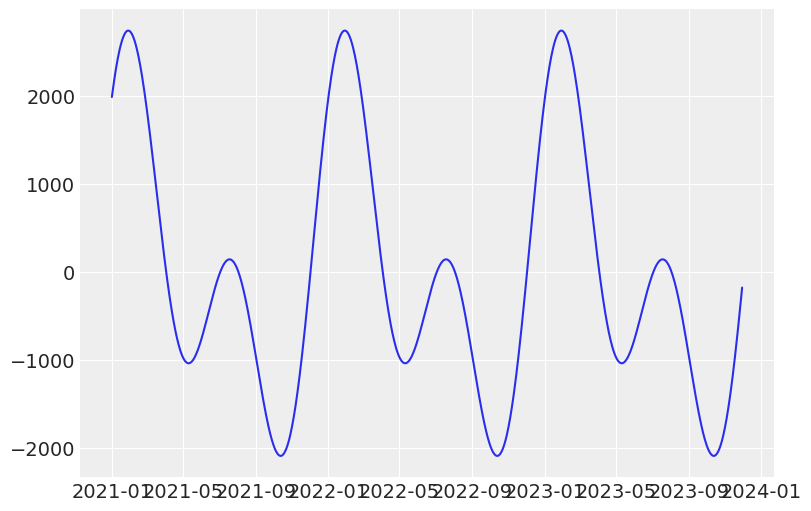

In [156]:
fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1000.0])

df['yr_season'] = np.dot(fourier_features, fourier_coefs)

plt.plot(df['fecha'], df['yr_season'])

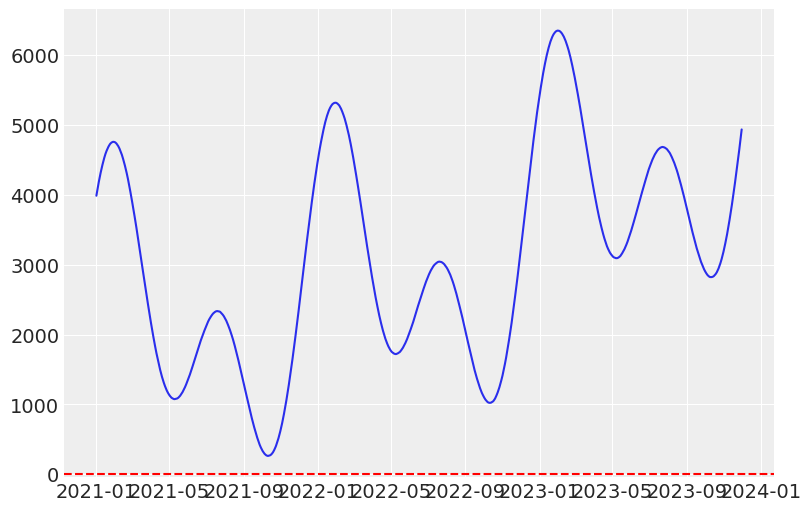

In [157]:
df['trnd_season'] = df['local_level'] + df['yr_season']

plt.plot(df['fecha'], df['trnd_season'])
plt.axhline(y=0, color='r', linestyle='--')

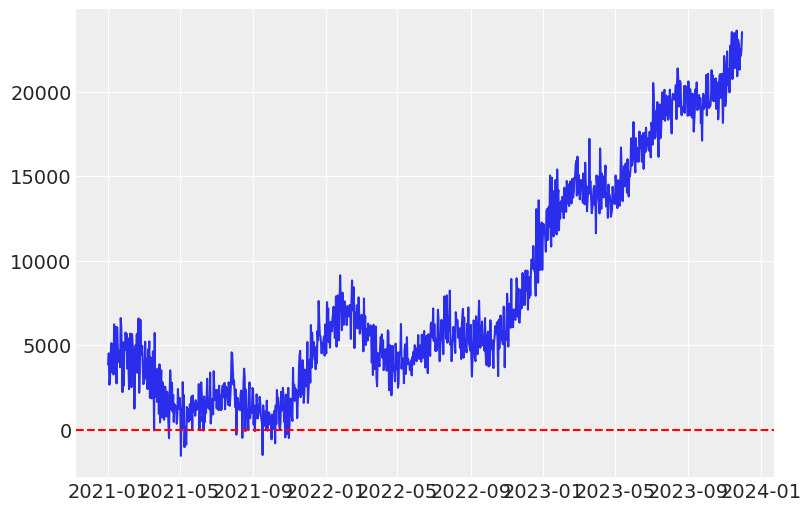

In [153]:
df['y'] = df['trnd_season'] + rng.normal(0, 1000, df.shape[0])

plt.plot(df["fecha"], df['y'])
plt.axhline(y=0, color='r', linestyle='--')

In [182]:
# https://marubon-ds.blogspot.com/2018/01/local-linear-trend-model-for-time.html
# 
N = len(y)

coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=False) as stochastic_trend_model_2:
    
    # X_data = pm.MutableData('X_data', t)
    Y_data = pm.MutableData('Y_data', y)
    
    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=1/sigma_lt)  
    sigma_local_level = pm.Exponential("sigma_local_level", lam=1/sigma_ll)  
    sigma             = pm.Exponential("sigma", lam=1/sigma_epsilon)              

    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=sigma_lt_0)
    local_level_0    = pm.Normal("local_level_0", mu=mu_ll_0, sigma=sigma_ll_0)
    
    local_level_aux  = pm.GaussianRandomWalk("local_level_aux", mu = local_level_0, sigma = sigma_local_level, dims="n_obs")
    local_trend_aux  = pm.GaussianRandomWalk("local_trend_aux", mu = 0, sigma = sigma_local_trend, dims="n_obs")
    
    local_trend = pm.Deterministic("local_trend", local_trend_aux + local_trend_0, dims="n_obs")
    local_level = pm.Normal("local_level", mu = local_level_aux[:-1] + local_trend_aux[:-1], sigma = sigma_local_level, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=local_level, sigma=sigma, dims="n_obs", observed=Y_data)

    stochastic_trend_prior_2 = pm.sample_prior_predictive()



c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Sampling: [local_level, local_level_0, local_level_aux, local_trend_0, local_trend_aux, sigma, sigma_local_level, sigma_local_trend, y_obs]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (99,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1682B0B19A0>), [100], 11, Add.0, sigma_local_level)
Toposort index: 14
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(99,)), TensorType(float64, shape=())]
Inputs shapes: ['No shapes', (1,), (), (99,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x1682B0B19A0, array([100], dtype=int64), array(11, dtype=int64), 'not shown', array(0.01206876)]
Outputs clients: [['output'], ['output', normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1682B0B26C0>), [100], 11, local_level, sigma)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.